# LSTM Model for Stock SPY

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import random

folder_path = "/Users/kang/Downloads/data"

feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

df_target = pd.read_parquet(target_path)
df_feature = pd.read_parquet(feature_path)

spy_data = df_feature[df_feature['stock_id'] == 50200]

print(spy_data.head())

          stock_id  time_id  seconds_in_bucket  bid_price1  ask_price1  \
13501269     50200       12                1.0      370.62      370.64   
13501270     50200       12                2.0      370.68      370.70   
13501271     50200       12                3.0      370.66      370.69   
13501272     50200       12                4.0      370.75      370.77   
13501273     50200       12                5.0      370.79      370.83   

          bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
13501269      370.61      370.65        100        100        200         63  
13501270      370.67      370.71          7        100        257        200  
13501271      370.64      370.70        200        100        100        300  
13501272      370.74      370.78        100        100        200        100  
13501273      370.78      370.84        557        400        500        300  


In [2]:
def compute_orderbook_features(spy_data):
    spy_data = spy_data.copy()

    spy_data['mid_price'] = (spy_data['bid_price1'] + spy_data['ask_price1']) / 2
    spy_data['wap'] = (spy_data['bid_price1'] * spy_data['ask_size1'] + spy_data['ask_price1'] * spy_data['bid_size1']) / (
        spy_data['bid_size1'] + spy_data['ask_size1']
    )
    spy_data['bid_ask_spread'] = spy_data['ask_price1'] - spy_data['bid_price1']
    spy_data['spread_pct'] = spy_data['bid_ask_spread'] / spy_data['mid_price']
    spy_data['spread_variation'] = spy_data.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )
    spy_data['imbalance'] = (spy_data['bid_size1'] - spy_data['ask_size1']) / (spy_data['bid_size1'] + spy_data['ask_size1'])
    spy_data['depth_ratio'] = spy_data['bid_size1'] / spy_data['ask_size1'].replace(0, np.nan)

    spy_data['wap_lag1'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].shift(1)
    spy_data['wap_return'] = (spy_data['wap'] - spy_data['wap_lag1']) / spy_data['wap_lag1']
    spy_data['log_return'] = np.log(spy_data['wap'] / spy_data['wap_lag1'].replace(0, np.nan))

    spy_data['wap_mean_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean())
    spy_data['wap_std_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std())

    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'wap_lag1', 'wap_return', 'log_return',
        'wap_mean_10', 'wap_std_10',
        'spread_pct', 'spread_variation',
        'imbalance','depth_ratio'
    ]
    return spy_data[keep_cols]


spy_feat = compute_orderbook_features(spy_data)

def realized_volatility(series):
    return np.sqrt(np.sum(np.square(np.diff(np.log(series)))))

rv_df = spy_feat.groupby("time_id")["wap"].apply(realized_volatility).reset_index()
rv_df.columns = ["time_id", "rv"]

feature_agg_base = spy_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std'],
    'depth_ratio': ['mean', 'std'],
})
feature_agg_base.columns = ['_'.join(col) for col in feature_agg_base.columns]
feature_agg_base = feature_agg_base.reset_index()

data = pd.merge(feature_agg_base, rv_df, on="time_id", how="inner")
data = data.sort_values("time_id").reset_index(drop=True)

## Baseline LSTM Model

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(3888)

In [4]:
class RollingWindowDataset(Dataset):
    def __init__(self, data, W=330, H=10, S=5):
        self.X = []
        self.y = []
        feature_cols = [col for col in data.columns if col not in ['time_id', 'rv']]
        
        data_array = data[feature_cols].values
        target_array = data['rv'].values
        
        for start_idx in range(0, len(data_array) - W - H + 1, S):
            end_idx = start_idx + W
            self.X.append(data_array[start_idx:end_idx])
            self.y.append(target_array[end_idx:end_idx + H])
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class LSTMForecast(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, output_dim=10, dropout=0.0):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        last_hidden = self.dropout(last_hidden)
        output = self.fc(last_hidden)
        return output

def build_lstm_model(input_dim, hidden_dim=64, num_layers=1, output_dim=10, dropout=0.0):
    return LSTMForecast(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim, dropout=dropout)

In [6]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    train_loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

    return model, train_loss_list, val_loss_list

In [7]:
def predict_and_flatten(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            preds = model(batch_x)
            all_preds.append(preds.numpy())
            all_targets.append(batch_y.numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_preds.flatten(), all_targets.flatten()


def qlike(y_true, y_pred):
    eps = 1e-8
    var_true = np.maximum(y_true**2, eps)
    var_pred = np.maximum(y_pred**2, eps)
    ratio = var_true / var_pred
    return np.mean(ratio - np.log(ratio) - 1)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    qlike_score = qlike(y_true, y_pred)
    return mse, qlike_score

In [8]:
def plot_loss_curves(train_loss_list, val_loss_list):
    plt.figure(figsize=(8,5))
    plt.plot(train_loss_list, label="Train Loss", marker='o')
    plt.plot(val_loss_list, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def plot_predictions(y_true, y_pred, mse, qlike_score):
    plt.figure(figsize=(18,6))
    plt.plot(y_pred, label="Predicted RV", alpha=0.7)
    plt.plot(y_true, label="True RV", alpha=0.7)
    plt.title(f"LSTM Forecast across all Sliding Windows\nMSE: {mse:.6f} | QLIKE: {qlike_score:.6f}")
    plt.xlabel("Flattened Horizon Steps")
    plt.ylabel("Realized Volatility")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def prepare_dataloaders(data, W=330, H=10, S=5, batch_size=32, val_ratio=0.2):
    dataset = RollingWindowDataset(data, W=W, H=H, S=S)
    num_samples = len(dataset)
    num_val = int(val_ratio * num_samples)
    num_train = num_samples - num_val

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [num_train, num_val],
        generator=torch.Generator().manual_seed(42)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def run_experiment_with_validation(data, 
                                    W=330, H=10, S=5, 
                                    batch_size=64, hidden_dim=128, num_layers=1, 
                                    learning_rate=0.001, epochs=50, val_ratio=0.2, dropout=0.0,
                                    baseline_mse=float('inf'), baseline_qlike=float('inf')):
    
    print("\n================================")
    print("Starting New Experiment with Config:")
    print(f"W={W}, H={H}, S={S}, batch_size={batch_size}, hidden_dim={hidden_dim}, num_layers={num_layers}, lr={learning_rate}, epochs={epochs}, dropout={dropout}")
    print("================================\n")

    train_loader, val_loader = prepare_dataloaders(data, W=W, H=H, S=S, batch_size=batch_size, val_ratio=val_ratio)

    input_dim = len([col for col in data.columns if col not in ['time_id', 'rv']])
    model = build_lstm_model(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=H, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    model, train_loss_list, val_loss_list = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=epochs)
    plot_loss_curves(train_loss_list, val_loss_list)

    preds_flatten, targets_flatten = predict_and_flatten(model, train_loader)
    mse, qlike_score = calculate_metrics(targets_flatten, preds_flatten)
    
    # spike_start = 1100
    # spike_end = 1150

    # plt.figure(figsize=(14, 4))
    # plt.plot(preds_flatten[spike_start:spike_end], label='Predicted')
    # plt.plot(targets_flatten[spike_start:spike_end], label='True')
    # plt.title("Zoom into Spike Region (Pred vs True)")
    # plt.legend()
    # plt.grid()
    # plt.show()


    mse_improvement = (baseline_mse - mse) / baseline_mse * 100
    qlike_improvement = (baseline_qlike - qlike_score) / baseline_qlike * 100

    print(f"\nFinal Train Set Results:")
    print(f"MSE: {mse:.6f}  |  Δ from baseline: {mse_improvement:.2f}%")
    print(f"QLIKE: {qlike_score:.6f}  |  Δ from baseline: {qlike_improvement:.2f}%")

    plot_predictions(targets_flatten, preds_flatten, mse, qlike_score)

    return model, mse, qlike_score



Starting New Experiment with Config:
W=330, H=10, S=5, batch_size=64, hidden_dim=128, num_layers=1, lr=0.001, epochs=50, dropout=0.0



/var/folders/cl/wjmt93nn75jfg6w_xl3w3x940000gn/T/ipykernel_9764/1025531560.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


Epoch 1/50 - Train Loss: 0.047780 - Val Loss: 0.028052
Epoch 10/50 - Train Loss: 0.000527 - Val Loss: 0.000530
Epoch 20/50 - Train Loss: 0.000092 - Val Loss: 0.000068
Epoch 30/50 - Train Loss: 0.000005 - Val Loss: 0.000046
Epoch 40/50 - Train Loss: 0.000002 - Val Loss: 0.000045
Epoch 50/50 - Train Loss: 0.000002 - Val Loss: 0.000046


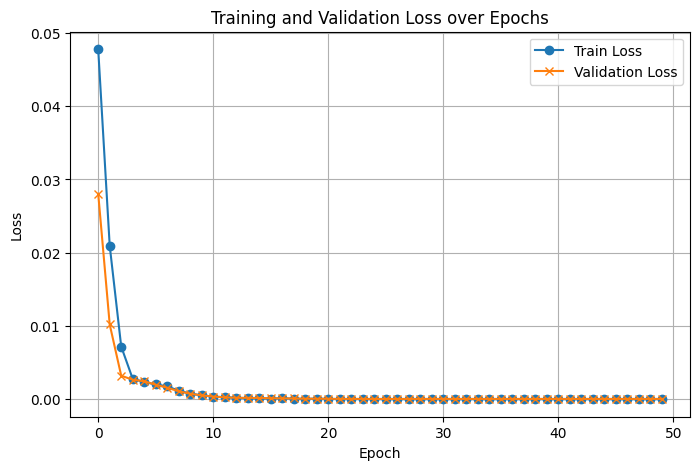


Final Train Set Results:
MSE: 0.000002  |  Δ from baseline: nan%
QLIKE: 5.505481  |  Δ from baseline: nan%


/var/folders/cl/wjmt93nn75jfg6w_xl3w3x940000gn/T/ipykernel_9764/2749837762.py:53: RuntimeWarning: invalid value encountered in scalar divide
  qlike_improvement = (baseline_qlike - qlike_score) / baseline_qlike * 100


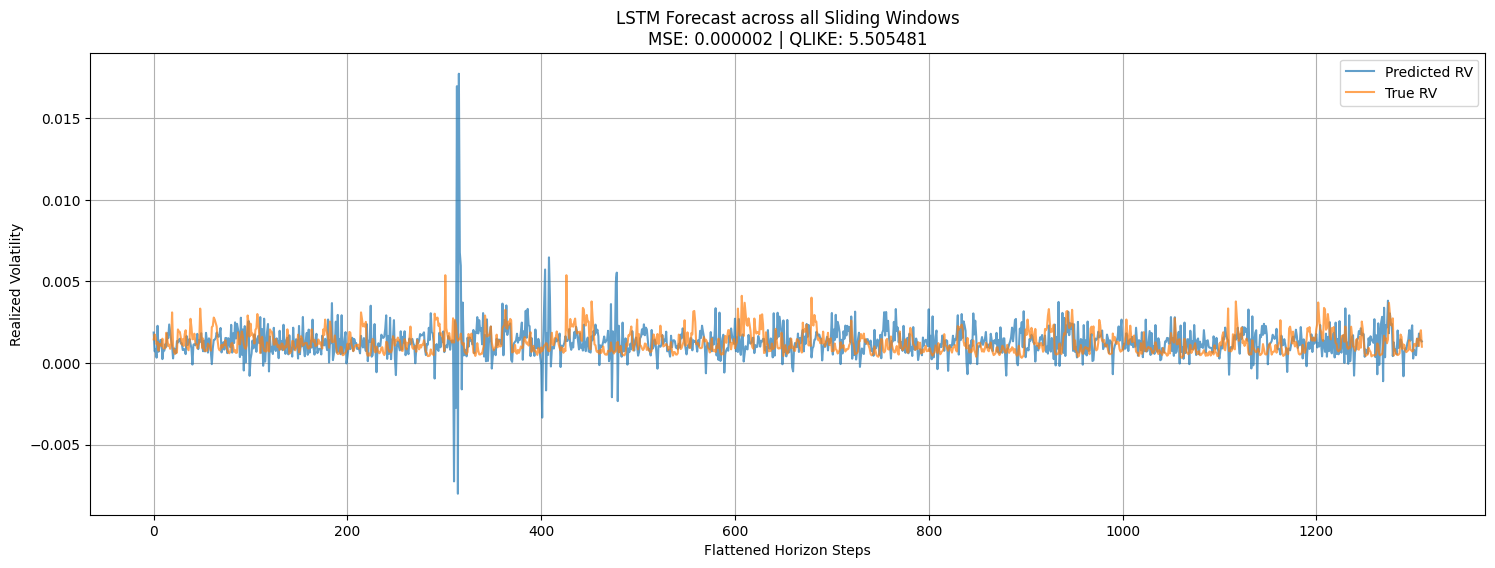

In [10]:
baseline_model, mse_baseline, qlike_score_baseline = run_experiment_with_validation(data)

## Tuning

The baseline model shows weakness when dealing with spike.
Round 1: increase hidden dim from 128 to 256, and number of layers from 1 to 2.


Starting New Experiment with Config:
W=330, H=10, S=5, batch_size=64, hidden_dim=256, num_layers=2, lr=0.001, epochs=50, dropout=0.0

Epoch 1/50 - Train Loss: 0.005933 - Val Loss: 0.001976
Epoch 10/50 - Train Loss: 0.000027 - Val Loss: 0.000025
Epoch 20/50 - Train Loss: 0.000003 - Val Loss: 0.000008
Epoch 30/50 - Train Loss: 0.000003 - Val Loss: 0.000007
Epoch 40/50 - Train Loss: 0.000002 - Val Loss: 0.000006
Epoch 50/50 - Train Loss: 0.000001 - Val Loss: 0.000005


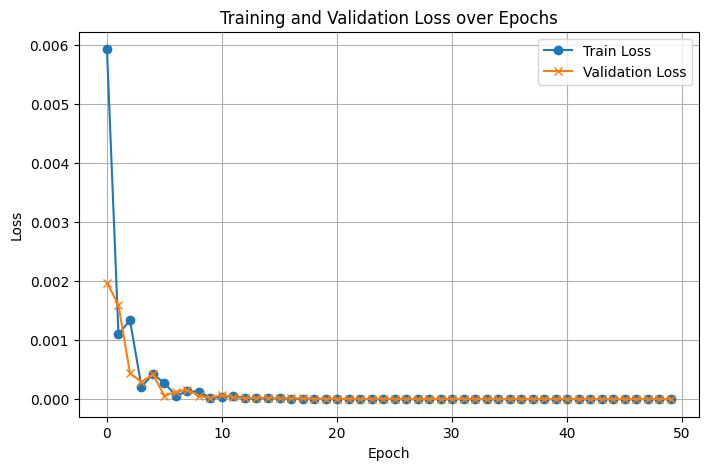


Final Train Set Results:
MSE: 0.000001  |  Δ from baseline: 31.15%
QLIKE: 6.603964  |  Δ from baseline: -19.95%


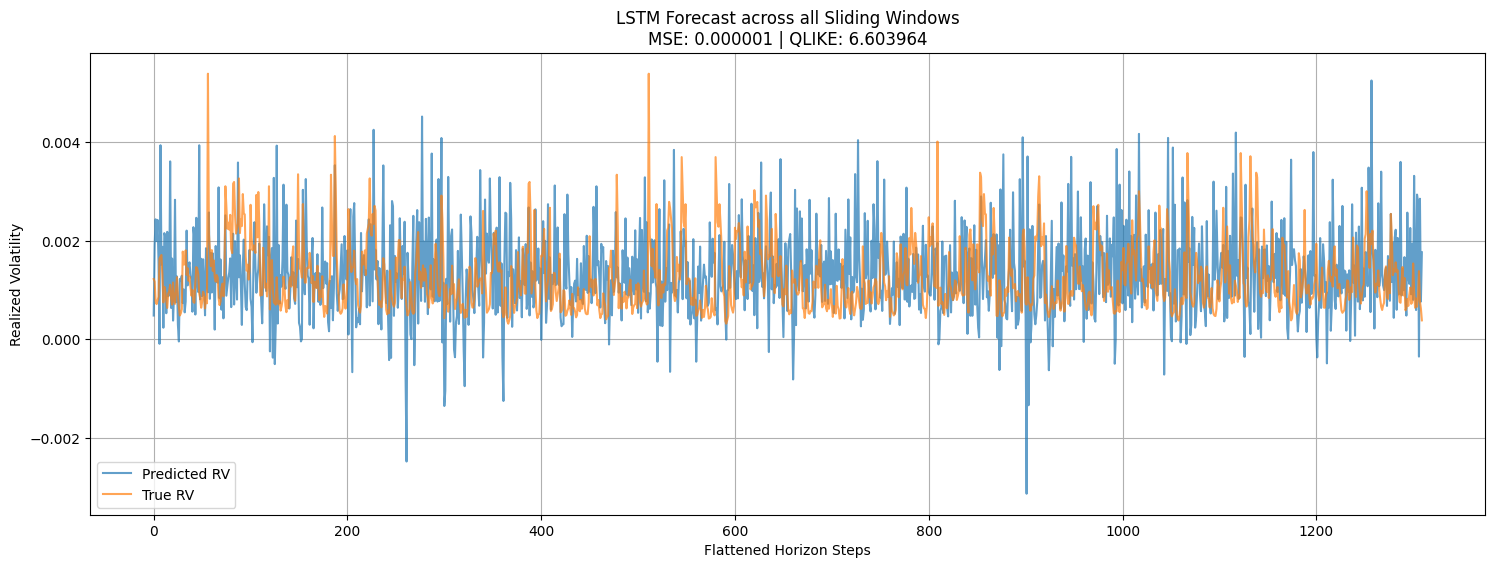

In [11]:
model, mse_r1, qlike_score_r1 = run_experiment_with_validation(
    data, 
    hidden_dim=256, 
    num_layers=2, 
    batch_size=64, 
    learning_rate=0.001, 
    epochs=50,
    baseline_mse=mse_baseline,
    baseline_qlike=qlike_score_baseline
)

increasing the layer and hidden dim smooth the spike, but increase the qlike.
try add some dropout to the model.


Starting New Experiment with Config:
W=330, H=10, S=5, batch_size=64, hidden_dim=256, num_layers=2, lr=0.001, epochs=50, dropout=0.2

Epoch 1/50 - Train Loss: 0.007399 - Val Loss: 0.001369
Epoch 10/50 - Train Loss: 0.000182 - Val Loss: 0.000050
Epoch 20/50 - Train Loss: 0.000049 - Val Loss: 0.000014
Epoch 30/50 - Train Loss: 0.000030 - Val Loss: 0.000005
Epoch 40/50 - Train Loss: 0.000020 - Val Loss: 0.000005
Epoch 50/50 - Train Loss: 0.000016 - Val Loss: 0.000004


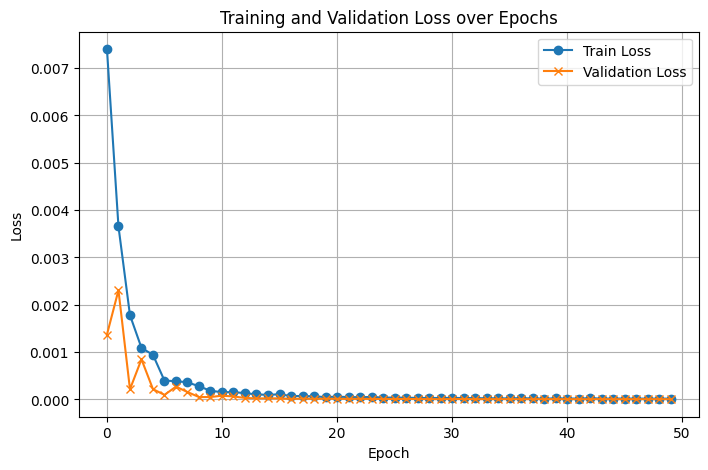


Final Train Set Results:
MSE: 0.000002  |  Δ from baseline: -72.60%
QLIKE: 1.542726  |  Δ from baseline: 76.64%


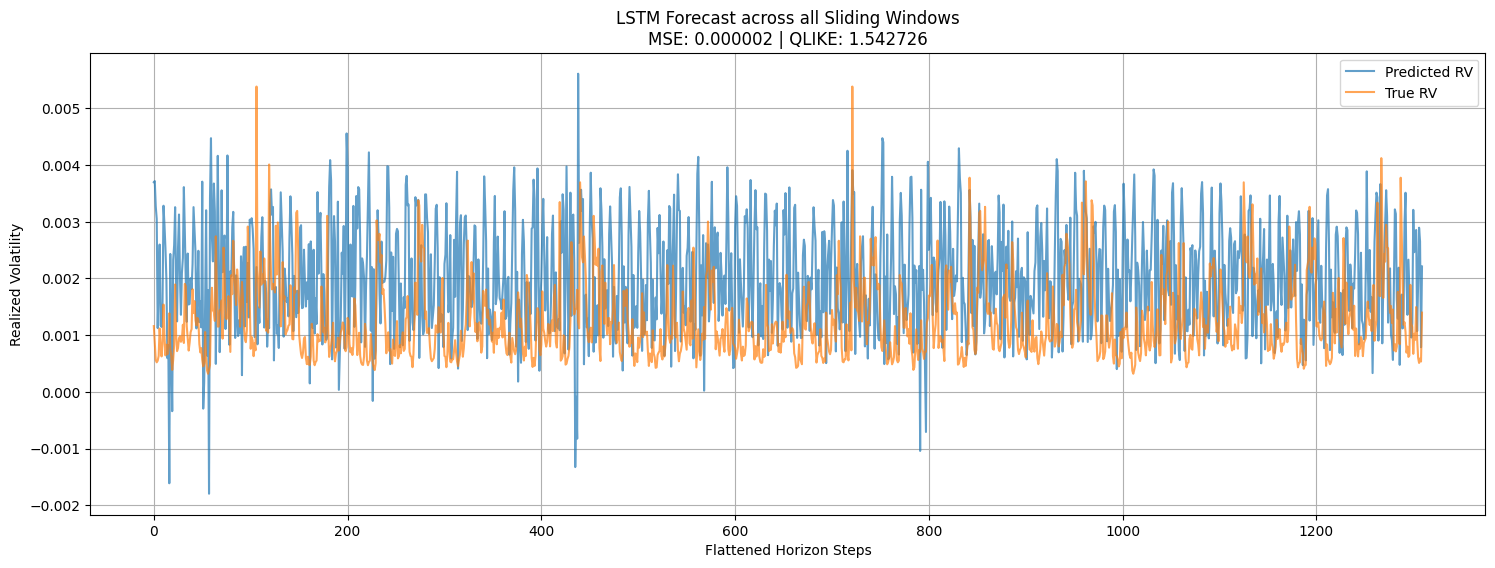

In [12]:
model, mse_r2, qlike_score_r2 = run_experiment_with_validation(
    data, 
    hidden_dim=256, 
    num_layers=2, 
    batch_size=64, 
    learning_rate=0.001, 
    epochs=50,
    dropout=0.2,
    baseline_mse=mse_r1,
    baseline_qlike=qlike_score_r1
)

try to decrease the dropout rate so that the model can learn more from the data.


Starting New Experiment with Config:
W=330, H=10, S=5, batch_size=64, hidden_dim=256, num_layers=2, lr=0.001, epochs=50, dropout=0.05

Epoch 1/50 - Train Loss: 0.006753 - Val Loss: 0.001629
Epoch 10/50 - Train Loss: 0.000116 - Val Loss: 0.000030
Epoch 20/50 - Train Loss: 0.000062 - Val Loss: 0.000015
Epoch 30/50 - Train Loss: 0.000052 - Val Loss: 0.000008
Epoch 40/50 - Train Loss: 0.000032 - Val Loss: 0.000007
Epoch 50/50 - Train Loss: 0.000032 - Val Loss: 0.000009


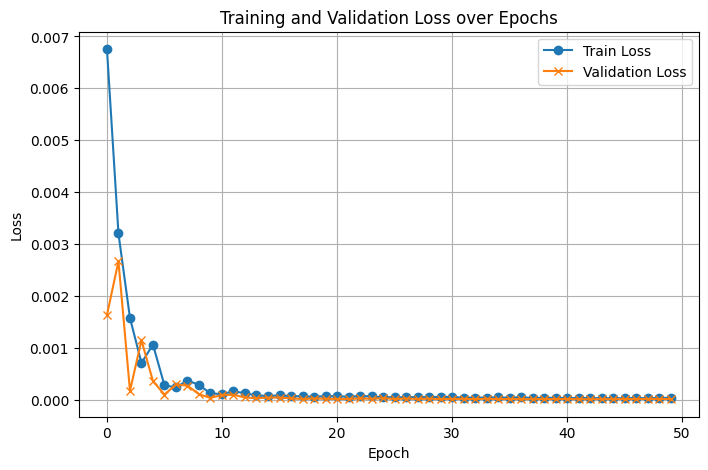


Final Train Set Results:
MSE: 0.000006  |  Δ from baseline: -232.03%
QLIKE: 7.200874  |  Δ from baseline: -366.76%


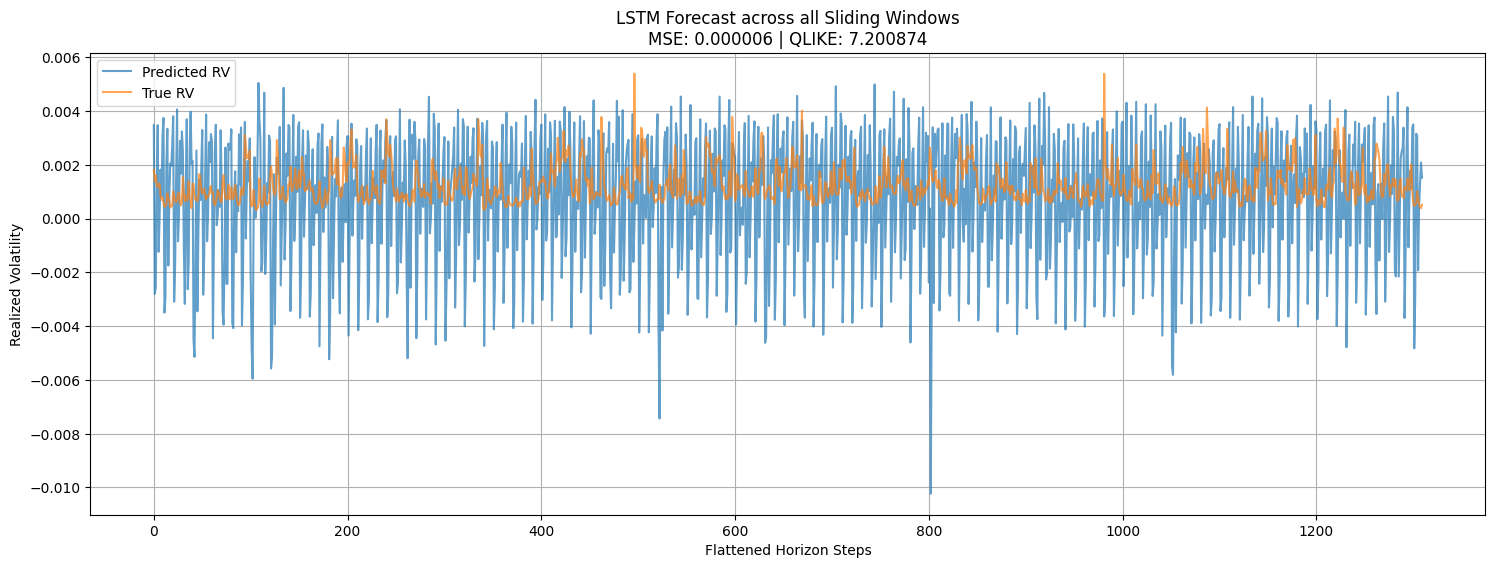

In [13]:
model, mse_r3, qlike_score_r3 = run_experiment_with_validation(
    data, 
    hidden_dim=256, 
    num_layers=2, 
    batch_size=64, 
    learning_rate=0.001, 
    epochs=50,
    dropout=0.05,
    baseline_mse=mse_r2,
    baseline_qlike=qlike_score_r2
)

base on the previous models, dropout will not help much. so remove the dropout layer.


Starting New Experiment with Config:
W=330, H=10, S=5, batch_size=64, hidden_dim=512, num_layers=3, lr=0.001, epochs=50, dropout=0.0

Epoch 1/50 - Train Loss: 0.020073 - Val Loss: 0.002491
Epoch 10/50 - Train Loss: 0.000043 - Val Loss: 0.000034
Epoch 20/50 - Train Loss: 0.000002 - Val Loss: 0.000001
Epoch 30/50 - Train Loss: 0.000001 - Val Loss: 0.000001
Epoch 40/50 - Train Loss: 0.000000 - Val Loss: 0.000001
Epoch 50/50 - Train Loss: 0.000001 - Val Loss: 0.000001


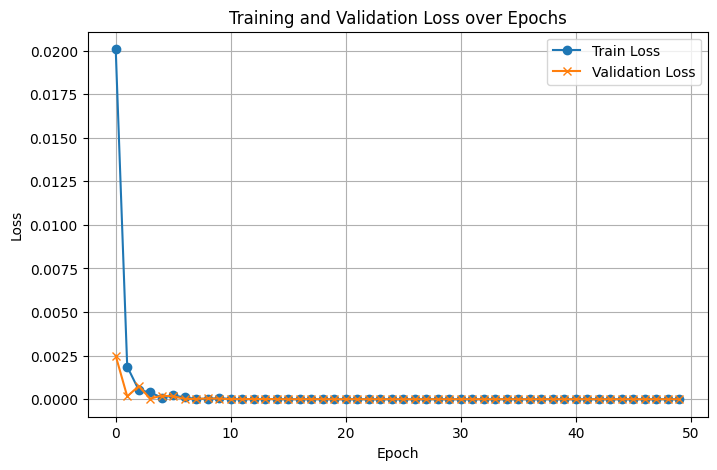


Final Train Set Results:
MSE: 0.000001  |  Δ from baseline: 35.68%
QLIKE: 6.592577  |  Δ from baseline: 0.17%


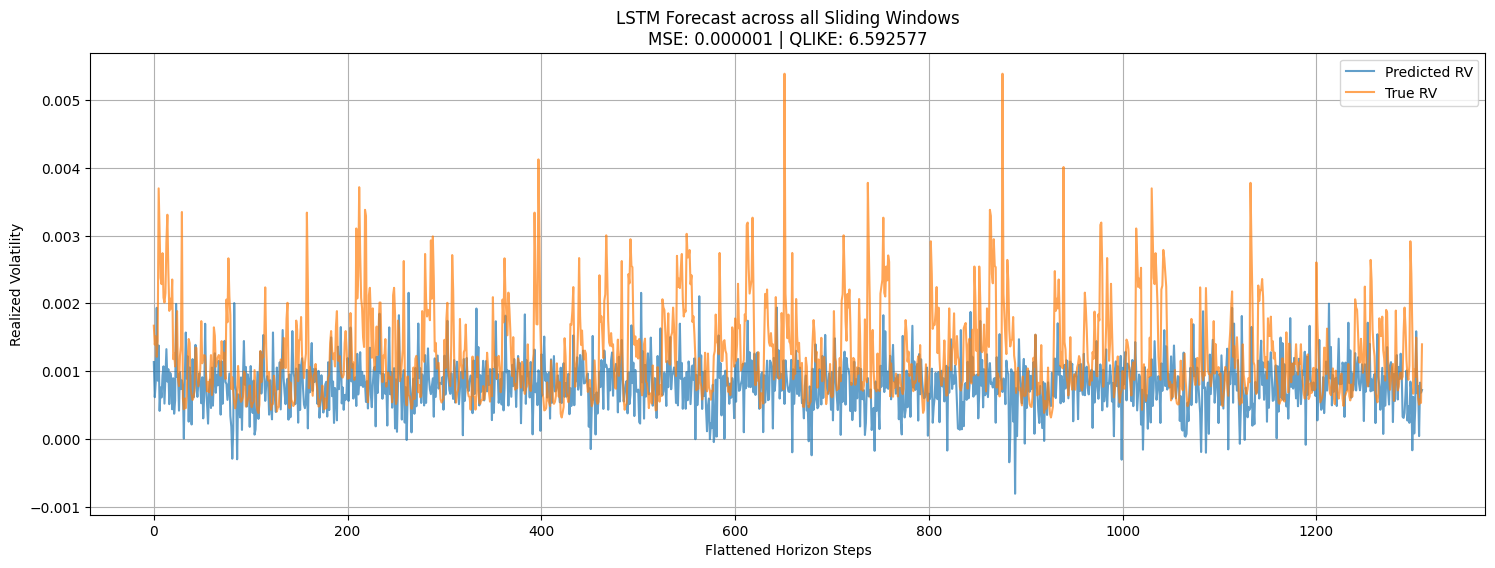

In [14]:
model, mse_r4, qlike_score_r4 = run_experiment_with_validation(
    data, 
    hidden_dim=512, 
    num_layers=3, 
    batch_size=64, 
    learning_rate=0.001, 
    epochs=50,
    baseline_mse=mse_r1,
    baseline_qlike=qlike_score_r1
)

notice that increasing the hidden dim and layer will decrease the qlike, but now it wont respond to the spike.


Starting New Experiment with Config:
W=330, H=10, S=5, batch_size=128, hidden_dim=256, num_layers=2, lr=0.001, epochs=50, dropout=0.0

Epoch 1/50 - Train Loss: 0.006612 - Val Loss: 0.006425
Epoch 10/50 - Train Loss: 0.000364 - Val Loss: 0.000210
Epoch 20/50 - Train Loss: 0.000024 - Val Loss: 0.000041
Epoch 30/50 - Train Loss: 0.000004 - Val Loss: 0.000008
Epoch 40/50 - Train Loss: 0.000002 - Val Loss: 0.000007
Epoch 50/50 - Train Loss: 0.000002 - Val Loss: 0.000004


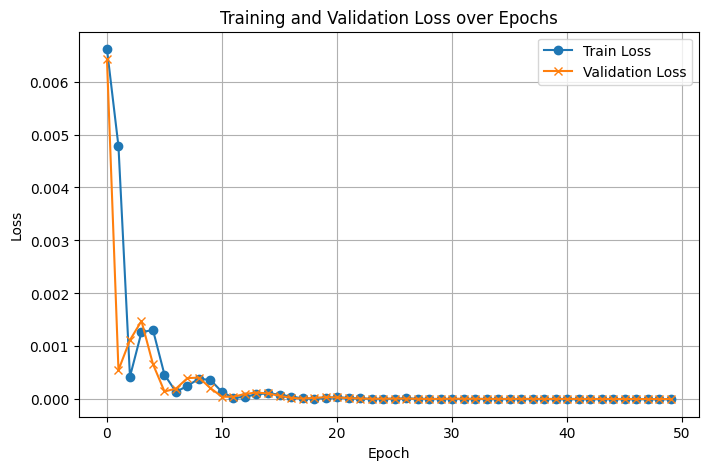


Final Train Set Results:
MSE: 0.000002  |  Δ from baseline: -35.94%
QLIKE: 9.081910  |  Δ from baseline: -37.52%


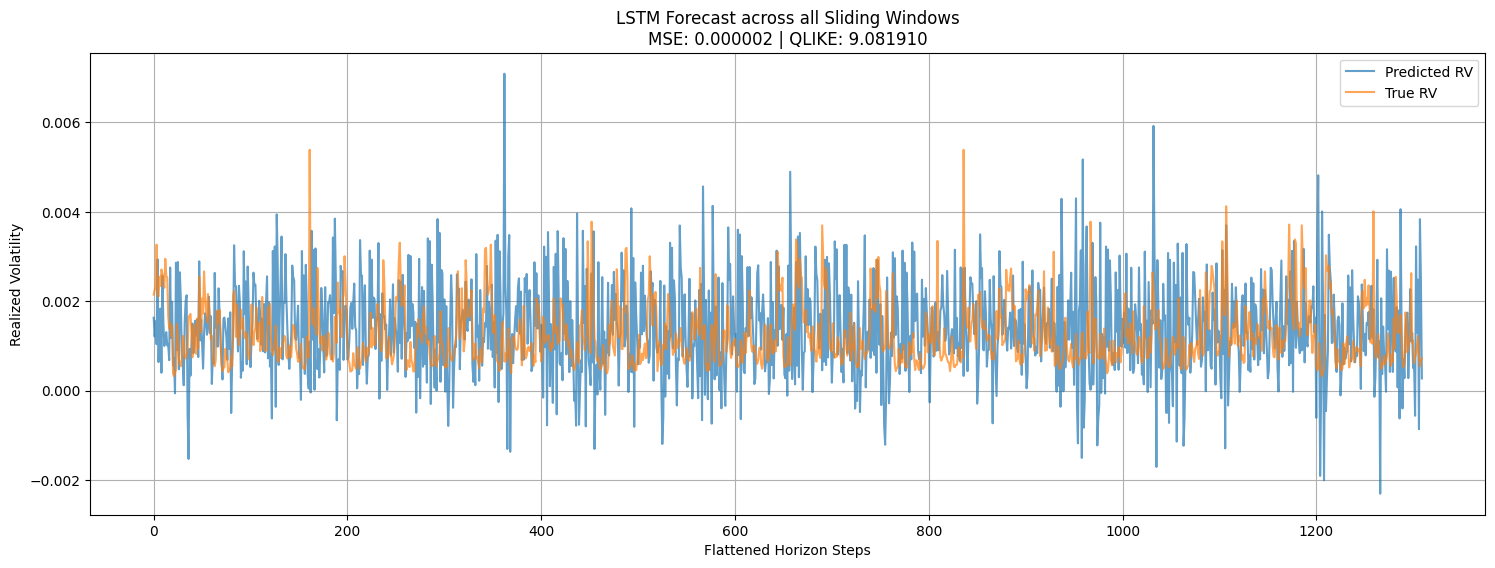

In [ ]:
model, mse_r5, qlike_score_r5 = run_experiment_with_validation(
    data, 
    hidden_dim=256, 
    num_layers=2, 
    batch_size=128, 
    learning_rate=0.001, 
    epochs=50,
    baseline_mse=mse_r1,
    baseline_qlike=qlike_score_r1
)

notice that the model is now responsive to the spike, but the qlike is not good. decrease the learning rate.


Starting New Experiment with Config:
W=330, H=10, S=5, batch_size=64, hidden_dim=128, num_layers=2, lr=0.001, epochs=50, dropout=0.0

Epoch 1/50 - Train Loss: 0.002323 - Val Loss: 0.001842
Epoch 10/50 - Train Loss: 0.000032 - Val Loss: 0.000062
Epoch 20/50 - Train Loss: 0.000003 - Val Loss: 0.000007
Epoch 30/50 - Train Loss: 0.000002 - Val Loss: 0.000006
Epoch 40/50 - Train Loss: 0.000001 - Val Loss: 0.000008
Epoch 50/50 - Train Loss: 0.000001 - Val Loss: 0.000007


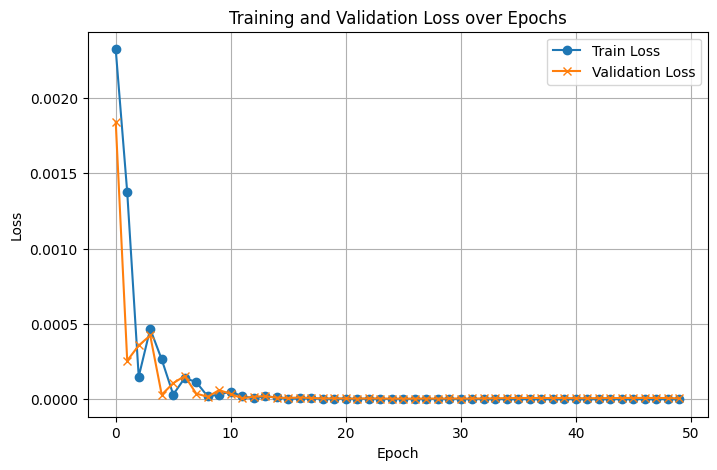


Final Train Set Results:
MSE: 0.000001  |  Δ from baseline: 38.84%
QLIKE: 2.568509  |  Δ from baseline: 71.72%


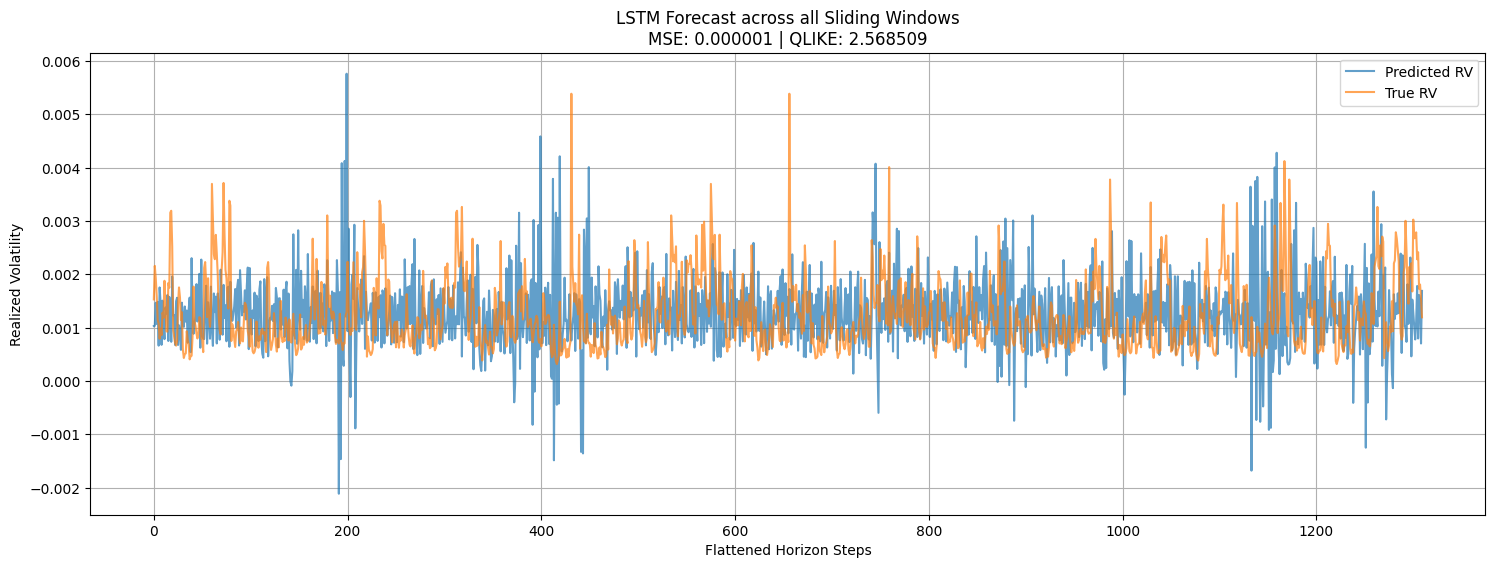

In [19]:
model, mse_r6, qlike_score_r6 = run_experiment_with_validation(
    data, 
    hidden_dim=128, 
    num_layers=2, 
    batch_size=64, 
    learning_rate=0.001, 
    epochs=50,
    baseline_mse=mse_r5,
    baseline_qlike=qlike_score_r5
)